# __PART 1__
## __Step 1.1__ Generate Low Resolution Images

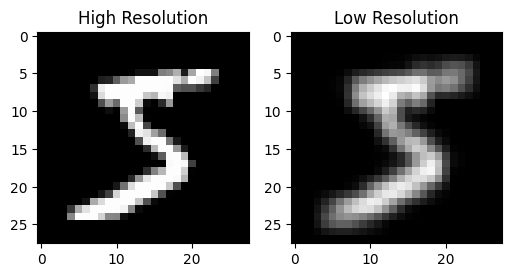

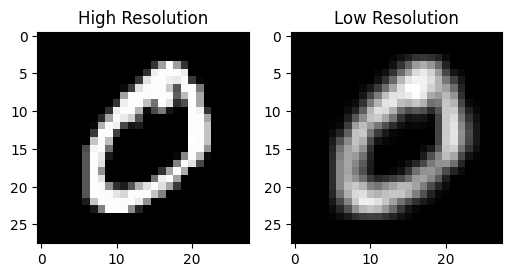

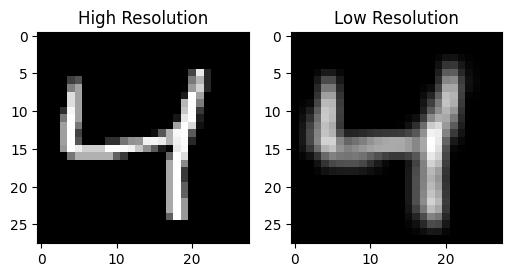

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

def main():
    # Load dataset
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Generate low-resolution versions
    low_res_train_images = [low_resolution(img) for img in train_images]
    low_res_test_images = [low_resolution(img) for img in test_images]

    # Display samples
    display_samples(train_images, low_res_train_images, sample_count=3)


def low_resolution(image):
    height, width = image.shape

    # Resize image to lower resolution and then back to the original size
    reduced_quality = tf.image.resize(image[..., tf.newaxis], (height // 2, width // 2))
    original_size = tf.image.resize(reduced_quality, (height, width))

    return tf.squeeze(original_size)

def display_samples(high_res_images, low_res_images, sample_count=3):
    for i in range(sample_count):
        plt.figure(figsize=(6, 3))
        plt.subplot(121)
        plt.imshow(high_res_images[i], cmap="gray")
        plt.title("High Resolution")
        plt.subplot(122)
        plt.imshow(low_res_images[i], cmap="gray")
        plt.title("Low Resolution")
        plt.show()

if __name__ == "__main__":
    main()

## __Step 1.2__ Design U-based Network

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np

def main():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    # Generate low-resolution versions
    low_res_train_images = np.array([low_resolution(img) for img in train_images])
    low_res_test_images = np.array([low_resolution(img) for img in test_images])

    # Normalize data
    low_res_train_images = low_res_train_images / 255.0
    low_res_test_images = low_res_test_images / 255.0

    # Add channel dimension
    low_res_train_images = low_res_train_images[..., tf.newaxis]
    low_res_test_images = low_res_test_images[..., tf.newaxis]

    # Create U-Net model
    OUTPUT_CLASSES = 10
    model = unet_model(output_channels=OUTPUT_CLASSES)

    # Print model summary
    model.summary()

    # Visualise model architecture
    plot_model(model, show_shapes=True)


def low_resolution(image):
    height, width = image.shape

    # Resize image to lower resolution and then back to the original size
    reduced_quality = tf.image.resize(image[..., tf.newaxis], (height // 2, width // 2))
    original_size = tf.image.resize(reduced_quality, (height, width))

    return tf.squeeze(original_size).numpy()

def unet_model(output_channels):
    inputs = Input(shape=[28, 28, 1])

    # Encoder
    conv1 = Conv2D(32, 3, activation="relu", padding="same")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation="relu", padding="same")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, 3, activation="relu", padding="same")(pool2)

    # Decoder
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), activation="relu", padding="same")(conv3)
    concat1 = concatenate([up1, conv2], axis=-1)
    conv4 = Conv2D(64, 3, activation="relu", padding="same")(concat1)

    up2 = Conv2DTranspose(32, 2, strides=(2, 2), activation="relu", padding="same")(conv4)
    concat2 = concatenate([up2, conv1], axis=-1)
    conv5 = Conv2D(32, 3, activation="relu", padding="same")(concat2)

    up3 = Conv2DTranspose(output_channels, 2, strides=(2, 2), activation="relu", padding="same")(conv5)


    model = Model(inputs=inputs, outputs=up3)

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

    return model

if __name__ == "__main__":
    main()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 28, 28, 32)           320       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)           0         ['conv2d_20[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 14, 14, 64)           18496     ['max_pooling2d_8[0][0]'

## __Step 1.3__ Train the model and check reconstruction accuracy

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 28, 28, 32)           320       ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)           0         ['conv2d_31[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_32 (Conv2D)          (None, 14, 14, 64)           18496     ['max_pooling2d_12[0][0]

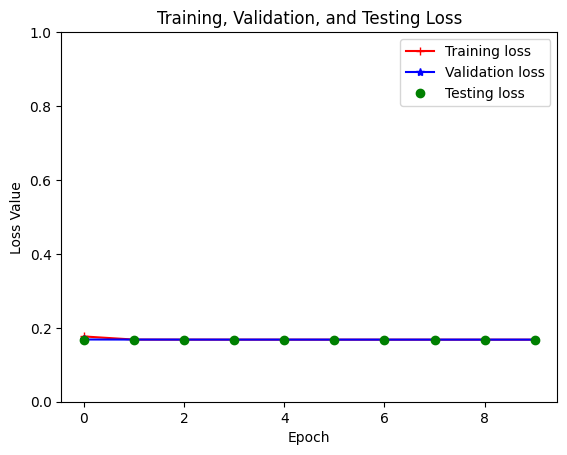

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt

class DisplayCallback(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss = self.model.evaluate(self.test_data, self.test_data, verbose=0)
        self.test_losses.append(test_loss if isinstance(test_loss, float) else test_loss[0])

def main():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    # Generate low-resolution versions
    low_res_train_images = np.array([low_resolution(img) for img in train_images])
    low_res_test_images = np.array([low_resolution(img) for img in test_images])

    # Normalize data
    low_res_train_images = low_res_train_images / 255.0
    low_res_test_images = low_res_test_images / 255.0

    # Add channel dimension
    low_res_train_images = low_res_train_images[..., tf.newaxis]
    low_res_test_images = low_res_test_images[..., tf.newaxis]

    # Split data into train, validation, and test sets
    val_images = low_res_train_images[:5000]
    val_labels = low_res_train_images[:5000]

    # Create U-Net model
    OUTPUT_CLASSES = 1
    model = unet_model(output_channels=OUTPUT_CLASSES)

    model.summary()

    # Train model
    EPOCHS = 10
    BATCH_SIZE = 64

    test_loss_callback = DisplayCallback(low_res_test_images)

    model_history = model.fit(
        low_res_train_images, low_res_train_images,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(val_images, val_labels),
        verbose=1,
        callbacks=[test_loss_callback]
    )

    # Plot training, validation, and testing loss
    plot_loss(model_history, test_loss_callback.test_losses)

def low_resolution(image):
    height, width = image.shape
    # Resize image to lower resolution and then back to the original size
    reduced_quality = tf.image.resize(image[..., tf.newaxis], (height // 2, width // 2))
    original_size = tf.image.resize(reduced_quality, (height, width))
    return tf.squeeze(original_size).numpy()

def unet_model(output_channels):
    inputs = Input(shape=[28, 28, 1])

    # Encoder
    conv1 = Conv2D(32, 3, activation="relu", padding="same")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation="relu", padding="same")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, 3, activation="relu", padding="same")(pool2)

    # Decoder
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), activation="relu", padding="same")(conv3)
    concat1 = concatenate([up1, conv2], axis=-1)
    conv4 = Conv2D(64, 3, activation="relu", padding="same")(concat1)

    up2 = Conv2DTranspose(32, 2, strides=(2, 2), activation="relu", padding="same")(conv4)
    concat2 = concatenate([up2, conv1], axis=-1)
    conv5 = Conv2D(32, 3, activation="relu", padding="same")(concat2)

    output_layer = Conv2D(output_channels, 1, activation="sigmoid", padding="same")(conv5)

    model = Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model

def plot_loss(model_history, test_losses):
    loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, "r+-", label="Training loss")
    plt.plot(epochs, val_loss, "b*-", label="Validation loss")
    plt.plot(epochs, test_losses, "go", label="Testing loss")
    plt.title("Training, Validation, and Testing Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

# __PART 2__

## __Step 2.1__ Modify the network

1/1 [==============================] - 0s 84ms/step


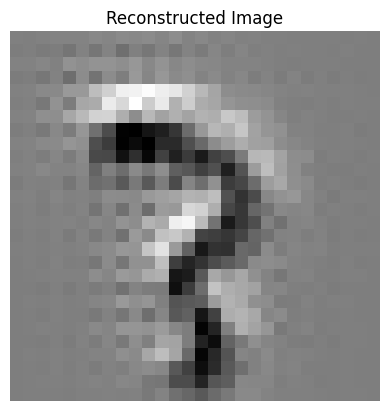

Class-wise scores (softmax probabilities):
Number 0: 10.05%
Number 1: 9.85%
Number 2: 10.02%
Number 3: 9.97%
Number 4: 9.91%
Number 5: 10.11%
Number 6: 10.08%
Number 7: 9.69%
Number 8: 10.19%
Number 9: 10.14%


In [134]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import random

def main():

    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    # Generate low-resolution versions
    low_res_train_images = np.array([low_resolution(img) for img in train_images])
    low_res_test_images = np.array([low_resolution(img) for img in test_images])

    # Normalize data
    low_res_train_images = low_res_train_images / 255.0
    low_res_test_images = low_res_test_images / 255.0

    # Add channel dimension
    low_res_train_images = low_res_train_images[..., tf.newaxis]
    low_res_test_images = low_res_test_images[..., tf.newaxis]

    # Create modified U-Net model
    OUTPUT_CLASSES = 1
    NUM_CLASSES = 10
    model = unet_model(output_channels=OUTPUT_CLASSES, num_classes=NUM_CLASSES)

    # Limit output to one random image for prediction (for brevity/efficiency purposes)
    random_index = random.randint(0, low_res_train_images.shape[0] - 1)
    single_image = low_res_train_images[random_index:random_index + 1]

    reconstructed_image, class_scores = model.predict(single_image)

    # Display reconstructed image and predictions
    display_results(reconstructed_image[0], class_scores[0])

def low_resolution(image):
    height, width = image.shape
    # Resize image to lower resolution and then back to the original size
    reduced_quality = tf.image.resize(image[..., tf.newaxis], (height // 2, width // 2))
    original_size = tf.image.resize(reduced_quality, (height, width))
    return tf.squeeze(original_size).numpy()

def unet_model(output_channels, num_classes):
    inputs = Input(shape=[28, 28, 1])

    # Encoder
    conv1 = Conv2D(32, 3, activation="relu", padding="same")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation="relu", padding="same")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, 3, activation="relu", padding="same")(pool2)

    # Decoder
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), activation="relu", padding="same")(conv3)
    concat1 = concatenate([up1, conv2], axis=-1)
    conv4 = Conv2D(64, 3, activation="relu", padding="same")(concat1)

    up2 = Conv2DTranspose(32, 2, strides=(2, 2), activation="relu", padding="same")(conv4)
    concat2 = concatenate([up2, conv1], axis=-1)
    conv5 = Conv2D(32, 3, activation="relu", padding="same")(concat2)

    output_image = Conv2D(output_channels, 1, activation="sigmoid", padding="same", name="output_image")(conv5)

    # Fully connected layers for classification
    x = Flatten()(conv3)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    logits = Dense(num_classes, activation=None)(x)
    output_class = tf.nn.softmax(logits, name="output_class")

    model = Model(inputs=inputs, outputs=[output_image, output_class])

    model.compile(optimizer="adam",
                  loss={"output_image": "binary_crossentropy", "output_class": "categorical_crossentropy"},
                  metrics={"output_image": "accuracy", "output_class": "accuracy"})

    return model

def display_results(reconstructed_image, class_scores):
    # Display reconstructed image
    plt.imshow(reconstructed_image.squeeze(), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()

    # Print class-wise scores
    print("Class-wise scores (softmax probabilities):")
    for i, score in enumerate(class_scores):
        score = score * 100
        print(f"Number {i}: {score:.2f}%")

if __name__ == "__main__":
    main()

## __Step 2.2__ Train the model with two loss functions

Model: "model_82"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_87 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_528 (Conv2D)         (None, 28, 28, 32)           320       ['input_87[0][0]']            
                                                                                                  
 max_pooling2d_175 (MaxPool  (None, 14, 14, 32)           0         ['conv2d_528[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 conv2d_529 (Conv2D)         (None, 14, 14, 64)           18496     ['max_pooling2d_175[0][

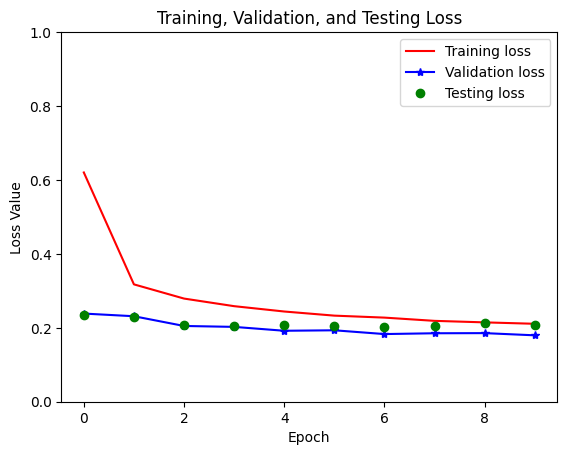

In [124]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt

class DisplayCallback(Callback):
    def __init__(self, test_data, test_labels):
        super().__init__()
        self.test_data = test_data
        self.test_labels = test_labels
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss = self.model.evaluate(self.test_data, {"output_image": self.test_data, "output_class": self.test_labels}, verbose=0)
        self.test_losses.append(test_loss)

def main():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    num_classes = 10
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

    # Generate low-resolution versions
    low_res_train_images = np.array([low_resolution(img) for img in train_images])
    low_res_test_images = np.array([low_resolution(img) for img in test_images])

    # Normalize data
    low_res_train_images = low_res_train_images / 255.0
    low_res_test_images = low_res_test_images / 255.0

    # Add channel dimension
    low_res_train_images = low_res_train_images[..., tf.newaxis]
    low_res_test_images = low_res_test_images[..., tf.newaxis]

    # Split data into train, validation, and test sets
    val_images = low_res_train_images[:5000]
    val_labels = train_labels[:5000]

    # Create model
    OUTPUT_CLASSES = 1
    model = unet_model(output_channels=OUTPUT_CLASSES, num_classes=num_classes)

    model.summary()

    # Train model
    EPOCHS = 10
    BATCH_SIZE = 64

    test_loss_callback = DisplayCallback(low_res_test_images, test_labels)

    model_history = model.fit(
        low_res_train_images, {"output_image": low_res_train_images, "output_class": train_labels},
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(val_images, {"output_image": val_images, "output_class": val_labels}),
        verbose=1,
        callbacks=[test_loss_callback]
    )

    # Plot training, validation, and testing loss
    plot_loss(model_history, test_loss_callback.test_losses)

def low_resolution(image):
    height, width = image.shape
    # Resize image to lower resolution and then back to the original size
    reduced_quality = tf.image.resize(image[..., tf.newaxis], (height // 2, width // 2))
    original_size = tf.image.resize(reduced_quality, (height, width))
    return tf.squeeze(original_size).numpy()

def unet_model(output_channels, num_classes):
    inputs = Input(shape=[28, 28, 1])

    # Encoder
    conv1 = Conv2D(32, 3, activation="relu", padding="same")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation="relu", padding="same")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, 3, activation="relu", padding="same")(pool2)

    # Decoder
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), activation="relu", padding="same")(conv3)
    concat1 = concatenate([up1, conv2], axis=-1)
    conv4 = Conv2D(64, 3, activation="relu", padding="same")(concat1)

    up2 = Conv2DTranspose(32, 2, strides=(2, 2), activation="relu", padding="same")(conv4)
    concat2 = concatenate([up2, conv1], axis=-1)
    conv5 = Conv2D(32, 3, activation="relu", padding="same")(concat2)

    output_image = Conv2D(output_channels, 1, activation="sigmoid", padding="same", name="output_image")(conv5)

    # Fully connected layers for classification
    x = Flatten()(conv3)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    logits = Dense(num_classes, activation="softmax", name="output_class")(x)

    model = Model(inputs=inputs, outputs=[output_image, logits])

    model.compile(optimizer="adam",
                  loss={"output_image": "binary_crossentropy", "output_class": "categorical_crossentropy"},
                  metrics={"output_image": "accuracy", "output_class": "accuracy"})

    return model

def plot_loss(model_history, test_losses):
    loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    test_loss = [t[0] for t in test_losses]
    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, "r+-", label="Training loss")
    plt.plot(epochs, val_loss, "b*-", label="Validation loss")
    plt.plot(epochs, test_loss, "go-", label="Testing loss")
    plt.title("Training, Validation, and Testing Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()